# Classificació d'imatges amb CNN

En aquest notebook, es mostra com classificar imatges amb una xarxa neuronal convolucional (CNN). Veurem també quin seria el rendiment d'una xarxa neuronal feedforward (FNN) en aquest mateix problema.

## Instal·lació de l'entorn

En primer lloc, instal·lem les llibreries necessàries per a executar el codi. En el nostre cas, necessitarem `torch`, `torchvision`, `datasets`, `scikit-learn`, `transformers`, `matplotlib`.

In [76]:
%pip install --upgrade torch torchvision  datasets scikit-learn transformers matplotlib torchinfo


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Ara importarem les llibreries necessàries per a fer classificació d'imatges utilitzant xarxes neuronals feed forward.

In [138]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

import datasets

from PIL import Image

Utilitzarem pytorch per a construir la xarxa neuronal i per a carregar el conjunt de dades.

## Preparem les dades

Com ja sabem, el rendiment de les xarxes neuronals _Feed Forward_ (FNN) en tasques de classificació d'imatges no és gaire bo. Això és degut a que les xarxes FNN no són capaces de capturar les relacions espacials entre els píxels de la imatge. Així i tot, començarem amb una xarxa FNN per a veure quin és el rendiment que podem obtenir.

Com a _DataSet_, utilitzarem el conjunt de dades `cats_vs_dogs` que obtindrem a continuació. Aquest conjunt de dades conté 25.000 imatges en color de 224x224 píxels, amb 2 classes diferents: 'Cat' i 'Dog'.

Son petites, però suficients per a mostrar com funcionen les xarxes neuronals en tasques de classificació d'imatges.

Utilitzarem `datasets` per a carregar el conjunt de dades i `DataLoader` per a carregar les dades en lots.

In [165]:
dataset = datasets.load_dataset('microsoft/cats_vs_dogs')

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})

Partim el dataset en dos parts, una per entrenar el model i una altra per avaluar-lo.

In [166]:
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

Vejam que les classes s'ha aplicat i algunes de les imatges.

In [167]:
print(dataset['train'][0])

print(dataset['train'].features)

classes = dataset['train'].features["labels"].names
classes

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x240 at 0x7F0FC9B4D690>, 'labels': 0}
{'image': Image(mode=None, decode=True, id=None), 'labels': ClassLabel(names=['cat', 'dog'], id=None)}


['cat', 'dog']

In [168]:
ds_train = dataset['train']
ds_test = dataset['test']

Mostrem algunes imatges del conjunt de dades.

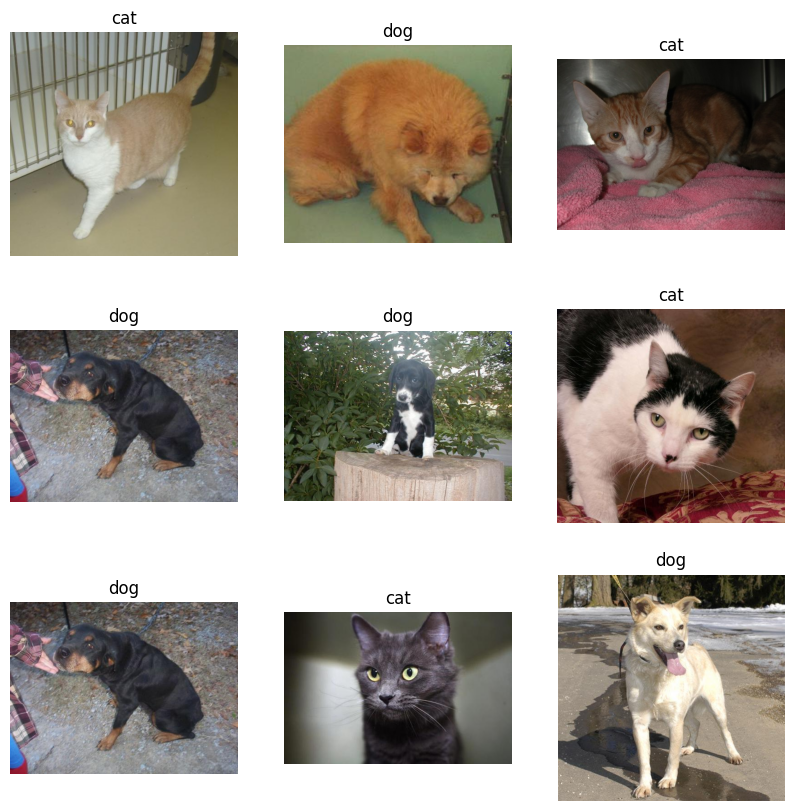

In [169]:
import matplotlib.pyplot as plt
import numpy as np

# Mostrem 3x3 imatges de gats i gossos
# Les imatges estan en format PIL

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    random_index = np.random.randint(0, len(ds_train))
    # mostrem el tamany de la imatge
    image = ds_train[random_index]['image']
    label = ds_train[random_index]['labels']
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(classes[label])

plt.show()

Les imatges tenen diferents dimensions, però les xarxes neuronals necessiten que totes les imatges tinguin les mateixes dimensions. Per això, redimensionarem les imatges a 128x128 píxels. Utilitzarem una transformació de `torchvision.transforms` per a fer-ho.

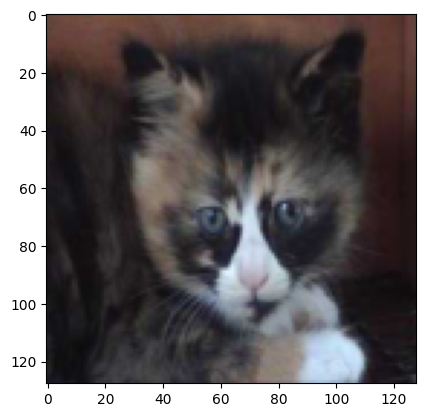

In [171]:
from torchvision.transforms import v2
transforms = v2.Compose([
    # Convertim a RGB
    v2.Lambda(lambda x: x.convert('RGB')),
    # Convertim la imatge a tensor, només necessari si tenim una imatge PIL
    v2.ToImage(),
    # Convertim la imatge a tensor, en valors de 0 a 1 i tiupe float32 (PyTorch espera això)
    v2.ToDtype(torch.float32, scale=True),
    # Redimensionem la imatge a 128x128
    v2.Resize(size=(128, 128), antialias=True),
    # Normalitzem els valors de la imatge segons la mitjana i la desviació estàndard de ImageNet
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
])
# Apliquem les transformacions a la primera imatge
image = dataset['train'][0]['image']
image = transforms(image)

# Per mostrar la imatge, hem de transposar les dimensions (C, H, W) -> (H, W, C)
plt.imshow(image.permute(1, 2, 0))
plt.show()

Per aplicar la transformació usarem el métode `map` de `datasets`, per a aplicar la transformació a cada imatge del conjunt de dades.

In [ ]:
def apply_transforms(sample):
    sample['image'] = transforms(sample['image'])
    return sample

ds_train = ds_train.map(apply_transforms)
ds_test = ds_test.map(apply_transforms)

In [ ]:
# Resetejem el format de les dades perquè siguin de tipus torch
ds_train.set_format(type='torch', columns=['image', 'labels'])
ds_test.set_format(type='torch', columns=['image', 'labels'])

Verifiquem que les imatges s'hagin redimensionat correctament.

In [147]:
image = ds_train[0]

print(image)

{'image': tensor([[[0.3807, 0.3987, 0.4048,  ..., 0.4038, 0.3801, 0.3599],
         [0.3859, 0.3839, 0.3989,  ..., 0.4038, 0.3801, 0.3599],
         [0.3879, 0.3757, 0.3887,  ..., 0.4038, 0.3801, 0.3599],
         ...,
         [0.1161, 0.1065, 0.0763,  ..., 0.1431, 0.1907, 0.2376],
         [0.1035, 0.0947, 0.0856,  ..., 0.1282, 0.1848, 0.2437],
         [0.1038, 0.0971, 0.0999,  ..., 0.1043, 0.1369, 0.2010]],

        [[0.2787, 0.2936, 0.2896,  ..., 0.2483, 0.2536, 0.2558],
         [0.2840, 0.2788, 0.2838,  ..., 0.2483, 0.2536, 0.2558],
         [0.2859, 0.2706, 0.2736,  ..., 0.2483, 0.2536, 0.2558],
         ...,
         [0.1114, 0.1018, 0.0716,  ..., 0.1392, 0.1867, 0.2337],
         [0.0959, 0.0871, 0.0779,  ..., 0.1243, 0.1809, 0.2398],
         [0.0960, 0.0892, 0.0920,  ..., 0.1004, 0.1330, 0.1971]],

        [[0.2277, 0.2442, 0.2451,  ..., 0.2395, 0.2347, 0.2287],
         [0.2330, 0.2294, 0.2393,  ..., 0.2395, 0.2347, 0.2287],
         [0.2350, 0.2212, 0.2290,  ..., 0.2395, 

In [148]:
# Creem un DataLoader per carregar les imatges

from torch.utils.data import DataLoader

def collate_fn(batch):
    images = [x['image'] for x in batch]
    labels = [x['labels'] for x in batch]
    
    tensor_images = torch.stack(images)
    tensor_labels = torch.tensor(labels)

    return tensor_images, tensor_labels
    
train_loader = DataLoader(ds_train, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(ds_test, batch_size=32, shuffle=False, collate_fn=collate_fn)

## Xarxes neuronals feed forward

### Creem el model

Ara crearem el model de xarxa neuronal. Començarem amb una xarxa feed forward. Aquesta xarxa tindrà una capa d'entrada, dues capes ocultes i una capa de sortida.

La capa d'entrada tindrà 128x128x3 = 49152 neurones, ja que les imatges redimensionades tenen 128x128 píxels i 3 canals (RGB).

Per triar les dimensions de les capes ocultes, hem de tenir en compte que les imatges són petites i que volem que el model sigui lleuger. Així i tot, volem que el model sigui prou gran com per a capturar les relacions espacials entre els píxels de les imatges. Per això, triarem dues capes ocultes amb 1024 i 512 neurones, respectivament.

La capa de sortida tindrà 2 neurones, ja que hi ha 2 classes diferents. Utilitzarem la funció d'activació `softmax` per a obtenir les probabilitats de pertànyer a cada classe.

In [ ]:
model = nn.Sequential( 
    # Sequential ens permet definir una xarxa neuronal com una sequencia de capes
    # Les dades venen transformades a vectors [0, 1] i aixó facilita l'entrenament de la xarxa
    # Transformem les dades d'entrada a un vector unidimensional
    nn.Flatten(),
    # Capa oculta amb 1024 neurones i funció d'activació relu.
    nn.Linear(128 * 128 * 3, 1024),
    nn.ReLU(),
    # Capa oculta amb 512 neurones i funció d'activació relu.
    nn.Linear(1024, 512),
    nn.ReLU(),
    # Capa de sortida amb 1 neurona i funció d'activació sigmoide.
    nn.Linear(512, 1),
    nn.Sigmoid()
)

# Mostrem un resum de la xarxa neuronal
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=49152, out_features=1024, bias=True)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=1, bias=True)
  (6): Sigmoid()
)

Ara entrenarem el model. Per a fer-ho, primer hem de compilar-lo. Utilitzarem l'optimitzador `adam` i la funció de pèrdua `BCELoss`. A més, monitoritzarem l'exactitud del model durant l'entrenament.

Un cop compilat el model, l'entrenarem durant 10 èpoques. Utilitzarem un lot de 128 imatges (batch size).

In [ ]:
def train(model, train_loader, num_epochs = 5):
    # Definim la funció de pèrdua i l'optimitzador
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    # Volem utilitzar la GPU si està disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Movem el model a la GPU. 
    model.to(device)

    history = {
        'loss': [],
        'accuracy': []
    }

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            # Accuracy
            # Per calcular l'accuracy, comparem la sortida de la xarxa amb les etiquetes
            # i calculem el percentatge de prediccions correctes.
            # Hem de fer unsquezze a les etiquetes perquè tinguin la mateixa forma que les prediccions
            # (un tensor de 1 dimensió amb la mateixa longitud que les prediccions)
            accuracy = ((outputs > 0.5) == labels.unsqueeze(1)).float().mean()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')
                print(f'Accuracy: {accuracy.item()}')
        
                history['loss'].append(loss.item())
                history['accuracy'].append(accuracy.item())

    return history

def validate(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    model.eval()
    criterion = nn.BCELoss()
    history = {
        'loss': [],
        'accuracy': []
    }

    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images = images.to(device)
            labels = labels.to(device).float()

            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            accuracy = ((outputs > 0.5) == labels.unsqueeze(1)).float().mean()

            history['loss'].append(loss.item())
            history['accuracy'].append(accuracy.item())
    
    print(f'Validation Loss: {np.mean(history["loss"])}')
    print(f'Validation Accuracy: {np.mean(history["accuracy"])}')

    return history

In [218]:
history = train(model, train_loader, num_epochs=10)
print('Finished Training')

KeyboardInterrupt: 

In [ ]:
history = validate(model, val_loader)
print('Finished Training')

Validation Loss: 49.965986394557824
Validation Accuracy: 0.5003401361355165
Finished Training


Com podem veure, no hem aconsseguit gran cosa, ja que el `val_accuracy` apenes passa del 50% (tenient dues classes és equivalent al que tindriem triant a cegues).

Graficarem les dades de l'entrenament per veure-ho més clar:

In [ ]:
def plot_history(history):
    plt.plot(history["loss"], label="train loss")
    accuracies = np.array(history["accuracy"]) *100
    plt.plot(accuracies, label="train accuracy")    
    plt.legend()
    plt.show()

In [ ]:
plot_history(history)

Podem veure com, en cap moment hem pogut començar a millorar en les nostres prediccions.

Les xarxes neuronals feed forward no són capaces de capturar les relacions espacials entre els píxels de les imatges. Això fa que siguin molt fàcils de sobreajustar, com hem vist. HAurem de provar amb una xarxa neuronal convolucional (CNN) per a veure si podem millorar el rendiment.

## Xarxes neuronals convolucionals (CNN)

De cara a la pràctica, la diferència més gran en la construcció de la xarxa neuronal és que afegirem capes convolucionals i de _pooling_.

Les capes convolucionals són capaces de capturar les relacions espacials entre els píxels de la imatge. Això és el que fa que les CNN siguin molt més eficients que les FNN en tasques de classificació d'imatges.

Les capes de _pooling_ són capaces de reduir la mida de les imatges, mantenint-ne les característiques més importants. Això baixa el nombre de paràmetres de la xarxa i fa que sigui més lleugera.

A més, afegirem capes de _dropout_ per a reduir l'overfitting.

### Creem el model

Ara crearem el model de xarxa neuronal convolucional. Aquesta xarxa tindrà una capa d'entrada, una capa convolucional, una capa densa i una capa de sortida.

A continuació l'entrenarem i veurem com es comporta.


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

# Definir el modelo en PyTorch
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=9, kernel_size=5),  # Sin padding por defecto
    nn.ReLU(),

    # Aplanado
    nn.Flatten(),

    # Capa densa final
    # Se debe calcular correctamente la dimensión de entrada
    # LA fórmula es: W - F + 2P
    # W: tamaño de la imagen
    # F: tamaño del filtro
    # P: padding
    # S: stride
    # En este caso, la imagen de entrada es de 128x128
    # El tamaño del filtro es 5
    # No hay padding
    # La dimensión de entrada es 9 * 124 * 124
    nn.Linear(9 * 124 * 124, 1),  
    nn.Sigmoid()
)

print(model)


Sequential(
  (0): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=138384, out_features=1, bias=True)
  (4): Sigmoid()
)


In [34]:
history = train(model, train_loader, num_epochs=10)
print('Finished Training')

Epoch [1/10], Step [100/586], Loss: 0.6902240514755249
Accuracy: 0.5
Epoch [1/10], Step [200/586], Loss: 0.6368549466133118
Accuracy: 0.6875
Epoch [1/10], Step [300/586], Loss: 0.6741926670074463
Accuracy: 0.5625
Epoch [1/10], Step [400/586], Loss: 0.6538048982620239
Accuracy: 0.65625
Epoch [1/10], Step [500/586], Loss: 0.6499431729316711
Accuracy: 0.5625
Epoch [2/10], Step [100/586], Loss: 0.6511801481246948
Accuracy: 0.59375
Epoch [2/10], Step [200/586], Loss: 0.5164334177970886
Accuracy: 0.75
Epoch [2/10], Step [300/586], Loss: 0.7379069924354553
Accuracy: 0.59375
Epoch [2/10], Step [400/586], Loss: 0.7459297180175781
Accuracy: 0.6875
Epoch [2/10], Step [500/586], Loss: 0.6248077154159546
Accuracy: 0.65625
Epoch [3/10], Step [100/586], Loss: 0.5646337270736694
Accuracy: 0.75
Epoch [3/10], Step [200/586], Loss: 0.6594358682632446
Accuracy: 0.71875
Epoch [3/10], Step [300/586], Loss: 0.4151134192943573
Accuracy: 0.84375
Epoch [3/10], Step [400/586], Loss: 0.43842682242393494
Accuracy:

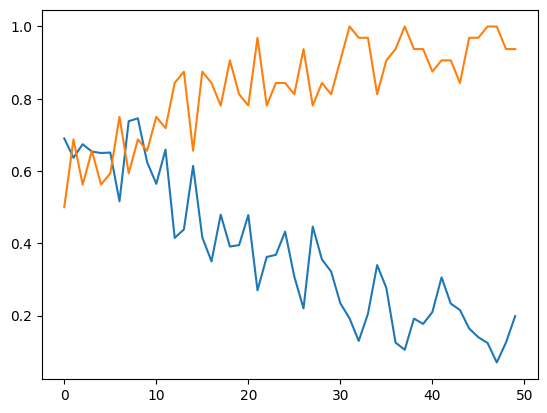

In [ ]:
plot_history(history)

In [ ]:
history = validate(model, val_loader)
print('Finished Training')

Validation Loss: 1.4164960928640122
Validation Accuracy: 0.6310911016949152
Finished Training


Podem veure com solament amb una capa convolucional i una capa densa el resultat ja es un poc millor que amb la xarxa feed forward. Ja es comencen a identificar patrons que identifiquen a gossos i gats, encara que podriem millorar molt el rendiment de la xarxa, especialment en la validació. Es fàcil observar com la xarxa està sobreajustant-se (memoritzant) a les dades d'entrenament.

Això és degut a que la xarxa és molt petita. Haurem d'apilar més capes convolucionals i de _pooling_ per a millorar el rendiment.

La primera capa convolucional capta patrons bàsics com línies i corbes. Si agreguem més capes convolucionals, aquestes podran capturar patrons més complexos com formes `bàsiques` i, finalment, l'objecte que volem classificar. També augmentarem el nombre de `filters` conforme anem afegint capes convolucionals, ja que conforme els patrons es compliquen hi haurà més possible combinacions de característiques interessants que caldrà capturar.

Per facilitar aquest procés, utilitzarem una tècnica molt útil: reduir el tamany espacial de les imatges. Si hem detectat que en una finestra de `3x3` hi ha una característica important, no ens importa si aquesta característica està en la part superior o inferior de la imatge. Així que podem reduir la mida de la imatge a la meitat. Això és el que fa la capa de _pooling_.

Hi ha dos tipus de _pooling_: _max pooling_ i _average pooling_. El _max pooling_ agafa el valor màxim de la finestra i l'_average pooling_ en fa la mitjana. En general, el _max pooling_ funciona millor que l'_average pooling_.

L'estructura bàsica serà la de capa convolucional, capa de _pooling_ i capa de _dropout_. La capa de _dropout_ és molt útil per a reduir l'overfitting.

Vejam com es comporta la xarxa amb aquesta nova estructura.

In [36]:
model = nn.Sequential(    
    # Capa Conv1
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, padding=2),  # 'same' padding = 2
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),

    # Capa Conv2
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),

    # Capa Conv3
    nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),

    # Aplanado y capa de salida
    nn.Flatten(),

    # 10240 = 40 * 16 * 16 (tamaño de la imagen después de 3 capas de pooling)
    nn.Linear(10240, 1),  # Ajustar si el tamaño de entrada cambia
    nn.Sigmoid()
)
model


Sequential(
  (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.2, inplace=False)
  (4): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.2, inplace=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=10240, out_features=1, bias=True)
  (14): Sigmoid()
)

In [37]:
history = train(model, train_loader, num_epochs=10)
print('Finished Training')

Epoch [1/10], Step [100/586], Loss: 0.8199202418327332
Accuracy: 0.3125
Epoch [1/10], Step [200/586], Loss: 0.6842679977416992
Accuracy: 0.6875
Epoch [1/10], Step [300/586], Loss: 0.6984606385231018
Accuracy: 0.5
Epoch [1/10], Step [400/586], Loss: 0.6355120539665222
Accuracy: 0.59375
Epoch [1/10], Step [500/586], Loss: 0.7488479614257812
Accuracy: 0.5
Epoch [2/10], Step [100/586], Loss: 0.6245527267456055
Accuracy: 0.65625
Epoch [2/10], Step [200/586], Loss: 0.696698009967804
Accuracy: 0.6875
Epoch [2/10], Step [300/586], Loss: 0.5812298655509949
Accuracy: 0.6875
Epoch [2/10], Step [400/586], Loss: 0.4928225874900818
Accuracy: 0.8125
Epoch [2/10], Step [500/586], Loss: 0.5524617433547974
Accuracy: 0.8125
Epoch [3/10], Step [100/586], Loss: 0.7802456617355347
Accuracy: 0.46875
Epoch [3/10], Step [200/586], Loss: 0.6794769167900085
Accuracy: 0.59375
Epoch [3/10], Step [300/586], Loss: 0.6153663396835327
Accuracy: 0.625
Epoch [3/10], Step [400/586], Loss: 0.46792036294937134
Accuracy: 0.

In [ ]:
plot_history(history)

In [38]:
history = validate(model, val_loader)
print('Finished Training')

Validation Loss: 0.4060314958598338
Validation Accuracy: 0.8122448977969942
Finished Training


Com podem veure, el rendiment de la xarxa ha millorat prou, encara que hi ha marge per a millorar. Hauriem pde seguir afegint capes convolucionals i de _pooling_ per a millorar el rendiment.

De tota manera anem a veure una altra técnica: _data augmentation_ aplicarem una série de filtres a les imatges (escalats i rotacions) per dversificar les dades d'entrada i, per tant ajudar a la xarxa a generalitzar-se.

En pytorch podem fer-ho fàcilment amb `torchvision.transforms`, que ja hem utilitzat per a redimensionar les imatges. Utilitzarem `AutoAugment` per a aplicar els filtres.

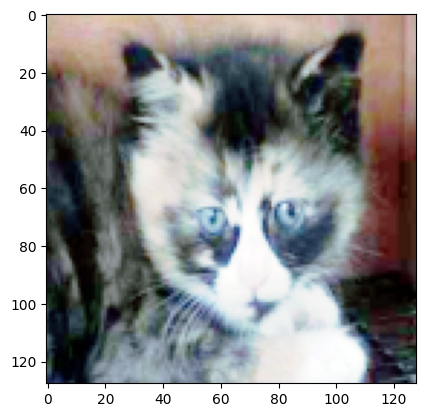

In [64]:
from torchvision.transforms import v2
transforms = v2.Compose([
    # Convertim a RGB
    # Apliquem les transformacions de data augmentation automàticament
    v2.AutoAugment(),
])

# Apliquem les transformacions a la primera imatge
image = ds_train[0]['image']
image_transformada = transforms(image)

# Per mostrar la imatge, hem de transposar les dimensions (C, H, W) -> (H, W, C)
plt.imshow(image_transformada.permute(1, 2, 0))
plt.show()

PEr aplicar els filtres, tornarem a aplicar la transformació a les imatges del conjunt de dades.

In [ ]:
# Creem un DataLoader per carregar les imatges
def apply_transforms(sample):
    try:
        sample['image'] = transforms(sample['image'])
        return sample
    except:
        return sample

ds_train = ds_train.map(apply_transforms)

print(ds_train[0])

Map:   0%|          | 0/18728 [00:00<?, ? examples/s]

{'image': tensor([[[0.7725, 0.8000, 0.8078,  ..., 0.8078, 0.7725, 0.7451],
         [0.7804, 0.7804, 0.8000,  ..., 0.8078, 0.7725, 0.7451],
         [0.7882, 0.7686, 0.7882,  ..., 0.8078, 0.7725, 0.7451],
         ...,
         [0.1843, 0.1490, 0.0314,  ..., 0.3059, 0.4784, 0.5725],
         [0.1333, 0.1020, 0.0549,  ..., 0.2353, 0.4667, 0.5882],
         [0.1333, 0.1020, 0.1176,  ..., 0.1333, 0.2863, 0.5059]],

        [[0.7176, 0.7490, 0.7412,  ..., 0.6667, 0.6706, 0.6784],
         [0.7294, 0.7176, 0.7294,  ..., 0.6667, 0.6706, 0.6784],
         [0.7373, 0.7059, 0.7098,  ..., 0.6667, 0.6706, 0.6784],
         ...,
         [0.2667, 0.2314, 0.0588,  ..., 0.3804, 0.5333, 0.6353],
         [0.1922, 0.1451, 0.0745,  ..., 0.3176, 0.5216, 0.6510],
         [0.1922, 0.1451, 0.1725,  ..., 0.2118, 0.3647, 0.5569]],

        [[0.6314, 0.6706, 0.6706,  ..., 0.6627, 0.6510, 0.6314],
         [0.6392, 0.6314, 0.6627,  ..., 0.6627, 0.6510, 0.6314],
         [0.6510, 0.6118, 0.6314,  ..., 0.6627, 

Recrearem el model, per assegurar que les dades son correctes.

In [67]:
model = nn.Sequential(    
    # Capa Conv1
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, padding=2),  # 'same' padding = 2
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),

    # Capa Conv2
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),

    # Capa Conv3
    nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.2),

    # Aplanado y capa de salida
    nn.Flatten(),

    # 10240 = 40 * 16 * 16 (tamaño de la imagen después de 3 capas de pooling)
    nn.Linear(10240, 1),  # Ajustar si el tamaño de entrada cambia
    nn.Sigmoid()
)
model

Sequential(
  (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.2, inplace=False)
  (4): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.2, inplace=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=10240, out_features=1, bias=True)
  (14): Sigmoid()
)

Finalment, entrenarem el model amb les dades augmentades. Es possible, però, que necessite més de 10 époques per convergir.

In [68]:
history = train(model, train_loader, num_epochs=10)

Epoch [1/10], Step [100/586], Loss: 0.6830400228500366
Accuracy: 0.59375
Epoch [1/10], Step [200/586], Loss: 0.6462236642837524
Accuracy: 0.6875
Epoch [1/10], Step [300/586], Loss: 0.6653985977172852
Accuracy: 0.5625
Epoch [1/10], Step [400/586], Loss: 0.6145206689834595
Accuracy: 0.59375
Epoch [1/10], Step [500/586], Loss: 0.7435804009437561
Accuracy: 0.46875
Epoch [2/10], Step [100/586], Loss: 0.6245952844619751
Accuracy: 0.625
Epoch [2/10], Step [200/586], Loss: 0.5286958813667297
Accuracy: 0.75
Epoch [2/10], Step [300/586], Loss: 0.6543962359428406
Accuracy: 0.6875
Epoch [2/10], Step [400/586], Loss: 0.6377700567245483
Accuracy: 0.5625
Epoch [2/10], Step [500/586], Loss: 0.5486988425254822
Accuracy: 0.78125
Epoch [3/10], Step [100/586], Loss: 0.6061886548995972
Accuracy: 0.625
Epoch [3/10], Step [200/586], Loss: 0.45547008514404297
Accuracy: 0.8125
Epoch [3/10], Step [300/586], Loss: 0.5995264053344727
Accuracy: 0.6875
Epoch [3/10], Step [400/586], Loss: 0.4752974808216095
Accuracy

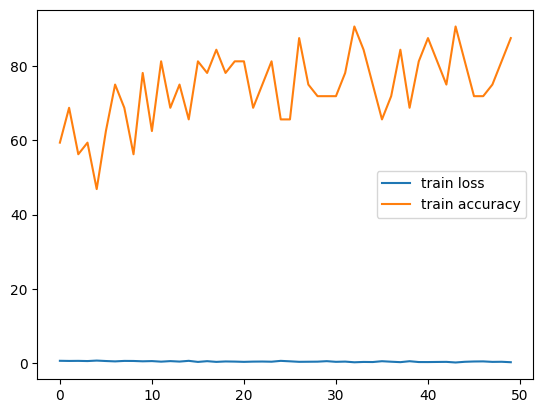

In [70]:
plot_history(history)

In [71]:
history = validate(model, val_loader)
print('Finished Training')

Validation Loss: 0.407099991935451
Validation Accuracy: 0.8109268708293941
Finished Training


Podem apreciar com el model millora amb les transformacions de data augmentation. Li costa més convergi, però si adquireix una major estabilitat en la seva precisió.

## Xarxes neuronals convolucionals (CNN) pre-entrenades

Com haurem vist, entrenar una xarxa neuronal convolucional des de zero és una tasca molt costosa. Això és degut a que les xarxes neuronals convolucionals tenen molts paràmetres i entrenar-les requereix moltes dades i temps.

Afortunadament, podem utilitzar xarxes neuronals convolucionals pre-entrenades. Això ens estalvia molt temps i recursos.

Veurem com afinar una xarxa neuronal convolucional pre-entrenada per a que classifique les nostres dades.



Com a exemple, utilitzarem la xarxa `VGG16` pre-entrenada. La xarxa `VGG16` és una xarxa neuronal convolucional molt coneguda i ha estat entrenada amb el conjunt de dades `ImageNet`, que conté més de 14 milions d'imatges i 1000 classes diferents. Està formada per 16 capes, d'aquí el nom. La xarxa `VGG16` és molt potent i ha demostrat ser molt eficient en tasques de classificació d'imatges.

El que farem serà utilitzar la xarxa `VGG16` pre-entrenada com a extractora de característiques. Això vol dir que utilitzarem les capes convolucionals de la xarxa `VGG16` per a extreure les característiques de les nostres imatges. A continuació, afegirem una capa densa per a classificar les imatges.

Per a no sobreajustar el model, utilitzarem la tècnica de _transfer learning_. Això vol dir que utilitzarem les característiques extretes per la xarxa `VGG16` per a entrenar només la capa densa. Això ens estalvia molt temps i recursos. Per a fer-ho, fixarem els paràmetres de les capes convolucionals de la xarxa `VGG16` i només entrenarem la capa densa.

In [ ]:
from torchvision import models

# Carreguem el model preentrenat VGG16
vgg16 = models.vgg16(pretrained=True)

# Congelem els paràmetres de la part convolucional. No volem entrenar-los, ja que ja han après a detectar característiques
for param in vgg16.features.parameters():
    param.requires_grad = False
 
# Creem un model amb la part convolucional de VGG16 i una capa densa final
model = nn.Sequential(
    # Part convolucional de VGG16
    vgg16.features,
    # Aplanat
    nn.Flatten(),        
    # Capa oculta de 8192 entrades (128 * 8 * 8) i 128 neurones
    # El 8 * 8 es el tamany de la imatge després de passar per VGG16
    nn.Linear(128 * 8 * 8, 128),
    # Funció d'activació ReLU per a la capa oculta
    nn.ReLU(),
    # Capa de sortida amb 1 neurona i funció d'activació sigmoide
    nn.Linear(128, 1), 
    nn.Sigmoid()
)

history = train(model, train_loader, num_epochs=10)

/home/carles/Documentos/notebooks/.venv/lib64/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/carles/Documentos/notebooks/.venv/lib64/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Step [100/586], Loss: 0.11677920818328857
Accuracy: 0.9375
Epoch [1/10], Step [200/586], Loss: 0.16230076551437378
Accuracy: 0.96875
Epoch [1/10], Step [300/586], Loss: 0.14450648427009583
Accuracy: 0.9375
Epoch [1/10], Step [400/586], Loss: 0.2350688874721527
Accuracy: 0.875
Epoch [1/10], Step [500/586], Loss: 0.19812791049480438
Accuracy: 0.875
Epoch [2/10], Step [100/586], Loss: 0.18212640285491943
Accuracy: 0.9375
Epoch [2/10], Step [200/586], Loss: 0.07643939554691315
Accuracy: 0.96875
Epoch [2/10], Step [300/586], Loss: 0.10981199145317078
Accuracy: 0.9375
Epoch [2/10], Step [400/586], Loss: 0.15386798977851868
Accuracy: 0.9375
Epoch [2/10], Step [500/586], Loss: 0.07183194905519485
Accuracy: 0.96875


KeyboardInterrupt: 

El resultat ara és molt millor. Això és degut a que hem pogut utilitzar les característiques apreses per la xarxa pre-entrenada per a classificar les imatges.

El _transfer learning_ és molt útil quan no tenim moltes dades o quan no tenim molts recursos per a entrenar una xarxa neuronal convolucional des de zero.

## Utilització en OpenCV

Per a utilitzar la xarxa neuronal convolucional pre-entrenada en OpenCV hauriem de convertir la xarxa a un format que OpenCV pugui llegir. Això és una mica complicat, però es pot fer. De tota manera en aquesta secció veurem com cridar al model de Keras des de OpenCV.

In [212]:
# En opencv carreguem una imatge, la classifiquem i la mostrem.

import cv2

def classify_image_opencv(image=None, path=None):
    if image is None and path is None:
        print("You must provide an image or a path")
        return
    
    if image is not None:
        # Convertim la imatge de PIL a opencv
        img = np.array(image)

        # Mostrem la imatge
        plt.imshow(img)
    elif path is not None:
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) # Carreguem la imatge amb opencv i la convertim a RGB
    

    img_class = img.copy()
    img_class = cv2.resize(img_class, (128, 128)) # Redimensionem la imatge a 128x128
    
    # Convertim la imatge a tensor
    img_class = transforms(Image.fromarray(img_class))
    img_class = img_class.unsqueeze(0) # Afegim una dimensió extra perquè PyTorch espera un batch d'imatges
    
    model.eval() # Posem el model en mode d'avaluació
    
    with torch.no_grad(): # Desactivem el càlcul del gradient perquè no el necessitem
        pred = model(img_class) # Classifiquem la imatge amb el model
    
    # Intepretem la sortida del model
    # Si la sortida és més gran que 0.5, és un gos, sinó és un gat
    if pred.item() < 0.5:
        print("Cat")
        cv2.putText(img, "Cat", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    else:
        print("Dog")
        cv2.putText(img, "Dog", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)


    plt.imshow(img)

Abans de fer proves recarregarem els datasets i no aplicarem les transformacions de data augmentation.

In [219]:
dataset = datasets.load_dataset('microsoft/cats_vs_dogs')
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

ds_train = dataset['train']
ds_test = dataset['test']

Cat


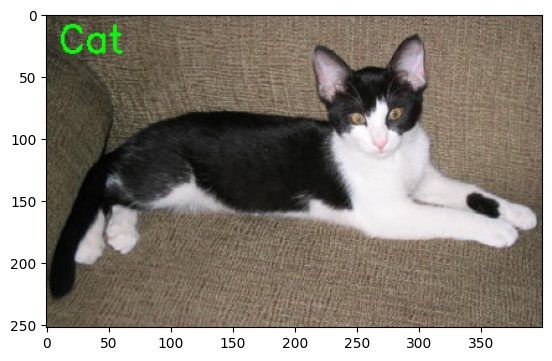

In [220]:
classify_image_opencv(ds_test[1]['image'])

Dog


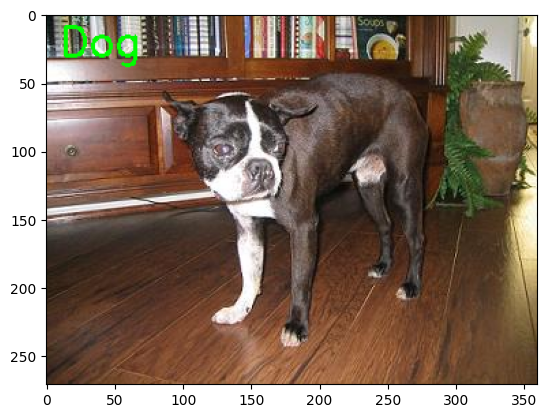

In [214]:
classify_image_opencv(ds_test[200]['image'])